# Introduction and main quantities

The quantities are expressed in the following units:
-   density in $10^{19}$ $m^{-3}$
-   temperature in $keV$
-   current in $MA$ 
-   power in $MW$
-   distances in $m$
-   magnetic field in $T$
-   time in $s$

Reminder:
- safety factor at $r=a$: $q_a$
- inverse of the aspect ratio: $\varepsilon=R/a$
- elongation: $\kappa=b/a$
- triangularity: $\delta$


# Governing Equations and Scaling Laws

In [33]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.constants import pi, e, k, mu_0

In [34]:
from scaling_laws import *

Here are the main constants $C_{loss}, C_{fus}, C_\beta, C_n$ and $C_I$

In [35]:
print(f'C_loss={C_loss}')  # OK
print(f'C_fus={C_fus}')  # OK
print(f'C_beta={C_beta}')  # OK
print(f'C_n={C_n}')  # OK
print(f'C_I={C_I}')  # OK

C_loss=0.08159430304832602
C_fus=0.001008275451791875
C_beta=0.6925939551082235
C_n=3.183098861837907
C_I=13.148529478957025


Let's use additional definition used by [Johner] 

In [36]:
print(f'Meff={Meff}')
print(f'C_loss={C_loss}')
print(f'C_fus={C_fus}')
print(f'C_beta={C_beta}')
print(f'C_I={C_I}') 

Meff=2.6666666666666665
C_loss=0.08159430304832602
C_fus=0.001008275451791875
C_beta=0.6925939551082235
C_I=13.148529478957025


The triple product $n \times T \times \tau_e$ as a function of $Q$:

In [37]:
# check from §2.8
nTtau_fromQ(Q=10)  # ~300 for Q --> +oo

267.58206128555094

In [38]:
_B = np.linspace(3, 9, 101)
_R = np.linspace(2, 10, 101)
_RR, _BB = np.meshgrid(_R, _B)

_beta_N1 = beta_N1(B=_BB, R=_RR)
_beta_N2 = beta_N2(B=_BB, R=_RR)

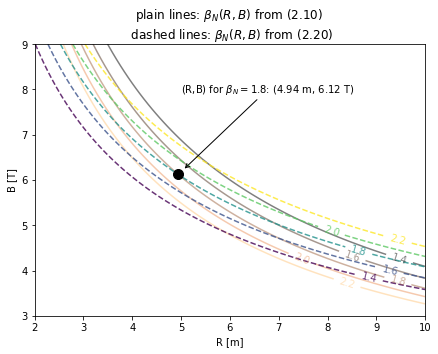

In [39]:
fig, ax = plt.subplots(figsize=(7,5))
c1=ax.contour(_RR, _BB, _beta_N1, levels=[1.4, 1.6, 1.8,  2, 2.2],
             alpha=0.5, cmap='copper')
ax.clabel(c1, inline=1, fontsize=10, fmt='%.1f')
c2=ax.contour(_RR, _BB, _beta_N2, levels=[1.4, 1.6,  1.8,  2, 2.2], 
              linestyles='dashed', alpha=0.8)
ax.clabel(c2, inline=1, fontsize=10, fmt='%.1f')
ax.set_xlabel('R [m]')
ax.set_ylabel('B [T]')
ax.set_title(r'plain lines: $\beta_N(R,B)$ from (2.10)'+' \n'+ r' dashed lines: $\beta_N(R,B)$ from (2.20)')

# determine the points where both beta_N are equals to the target (common points)
# from the contour lines
# beta_N_target = 1.8 -> 3rd line on contour
RB_sol1 = c1.allsegs[2][0]
RB_sol2 = c2.allsegs[2][0]
B_sol1 = RB_sol1[:,1]
B_sol2 = np.interp(RB_sol1[:,0], RB_sol2[:,0], RB_sol2[:,1])  # interpolate to be able to find the nearest value 

R_sol = RB_sol1[np.argmin(np.abs(B_sol1 - B_sol2)), 0]
B_sol = RB_sol1[np.argmin(np.abs(B_sol1 - B_sol2)), 1]

ax.plot(R_sol, B_sol, '.', ms=20, color='k')

ax.annotate(fr'(R,B) for $\beta_N=1.8$: ({R_sol:.2f} m, {B_sol:.2f} T)', 
            xy=(R_sol+.1, B_sol+.1), xytext=(5,8),
            arrowprops={'arrowstyle': '->'}, va='center')

fig.savefig('beta_N.png', dpi=150)

Since there is two equations $\beta_{N,1}(R,B)$ and $\beta_{N,2}(R,B)$, we solve for $(R,B)$ 

In [40]:
# for each R, find the points B for which beta_N1 = beta_N2
from scipy.optimize import fsolve

def diff_beta_N12(B, R):
    return beta_N1(R=R, B=B) - beta_N2(R=R, B=B)

B_sol12 = []
B0 = 5
for R in _R:
    B_sol12.append(fsolve(diff_beta_N12, B0, args=R))
B_sol12 = np.array(B_sol12).squeeze()

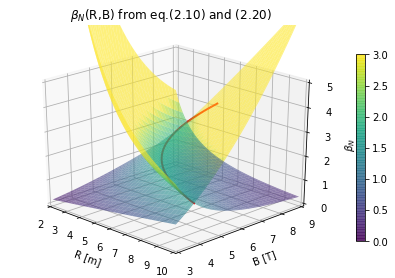

In [41]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c=ax.plot_surface(_RR, _BB, _beta_N1, alpha=0.6, cmap=cm.viridis, vmin=0, vmax=3)
ax.plot_surface(_RR, _BB, _beta_N2, alpha=0.6, cmap=cm.viridis, vmin=0, vmax=3)
ax.set_xlabel('R [m]')
ax.set_ylabel('B [T]')
ax.set_zlabel(r'$\beta_N$')
ax.set_aspect('equal')
ax.set_zlim(0, 5)
ax.plot(_R, B_sol12, beta_N1(R=_R, B=B_sol12), color='r', lw=2)
ax.set_xlim(2, 10)
ax.set_ylim(3, 9)
ax.view_init(azim=-45, elev=25)
fig.colorbar(c, shrink=0.7)
fig.tight_layout()
ax.set_title(r'$\beta_N$(R,B) from eq.(2.10) and (2.20)')
fig.savefig('beta_N_3D.png', dpi=150)

In [42]:
# relative distance between the two surfaces
delta_beta_N12 = 2*np.abs(_beta_N1 - _beta_N2)/(_beta_N1 + _beta_N2)

Text(0.5, 1.0, '$\\Delta\\beta_N(R,B_0)$')

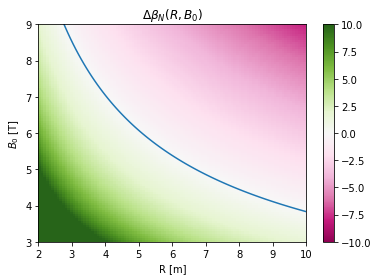

In [43]:
fig, ax = plt.subplots()
c=ax.pcolor(_R, _B, diff_beta_N12(_BB, _RR), cmap='PiYG', vmin=-10, vmax=10)
fig.colorbar(c)
ax.set_ylim(3,9)
ax.set_xlim(2, 10)
ax.plot(_R, B_sol12)
#ax.plot(_R, B_sol13)
ax.set_xlabel('R [m]')
ax.set_ylabel('$B_0$ [T]')
ax.set_title(r'$\Delta\beta_N(R,B_0)$')

# Retrieving ITER Parameters

# Solving from minimization

## Solving for $\beta_N(R,B)$

In [44]:
# return the distance between between the target beta_N and the beta_N functions of (R,B)
# this function is minimized to find the optimal (R,B) to get the prescribed beta_N
def obj_fun_beta(x, beta_N=1.8):  
    # parameters to find
    R, B = x 
    
    _beta_N1 = beta_N1(R=R, B=B)
    _beta_N2 = beta_N2(R=R, B=B)

    # return scalar objective function
    return np.sqrt((beta_N - _beta_N1)**2 + (beta_N - _beta_N2)**2)

In [45]:
R0, B0 = 5, 4
x0 = [R0, B0]

x = minimize(obj_fun_beta, x0, args=[1.8])
print(f'Solution found: R={x.x[0]:.2f} m, B={x.x[1]:.2f} T')

Solution found: R=4.94 m, B=6.12 T


## Solving directly for (R,B) - not working

In [46]:
C_loss/C_fus

80.92461529567066

In [47]:
# R^a B^b expressions
def RB1(Q=10, lambd=ratio, M=2.7, kappa=1.7, epsilon=0.323, qa=3, n_N=0.85, beta_N=1.8):
    " return R**0.42 * B**0.73 "
    C_SL = 0.0562 # constant coef
    # from (n*T*Tau)^0.31
    _temp = C_SL * C_n**0.41 * C_I **0.96 * C_beta**0.38 * \
            M**0.19 * kappa**0.09 * epsilon**0.68 * qa**(-0.96) * n_N**0.41 * beta_N**(-0.38)
        
    return (C_loss/C_fus * Q/(1+Q/lambd))**0.31 / (_temp)

def RB2(P_DT=410, kappa=1.7, epsilon=0.323, qa=3, beta_N=1.8):
    " return R**3 * B**4 "
    return P_DT / (C_beta**(-2) * C_fus * C_I**2 * qa**(-2) * kappa * epsilon**(4) * beta_N**(2))

In [48]:
# initialise with ITER data 
Q_target = 10
Pfus_target = 410

beta_N_target = 1.8
n_N_target = 0.85
qa_target = 3
kappa_target = 1.7
epsilon_target = 0.323

In [49]:
RB1_target = RB1(Q_target, 
                lambd=ratio, M=Meff, kappa=kappa_target, 
                epsilon=epsilon_target, qa=qa_target, 
                n_N=n_N_target, beta_N=beta_N_target)

RB2_target = RB2(Pfus_target, 
                kappa=kappa_target, epsilon=epsilon_target, 
                qa=qa_target, beta_N=beta_N_target)

RB_target = [RB1_target, RB2_target]

print(f'RB1_target={RB1_target}')
print(f'RB2_target={RB2_target}')

RB1_target=39.73276773979957
RB2_target=169373.7785534574


In [50]:
R_ITER = 6.2
B_ITER = 5.3

b1_ITER = R_ITER**0.42 * B_ITER**0.73
b2_ITER = R_ITER**3 * B_ITER**4
print(f'ITER: R^{0.42} B^{0.73}={b1_ITER}, R^3 B^4={b2_ITER}')

ITER: R^0.42 B^0.73=7.269857437594987, R^3 B^4=188052.2555768


In [51]:
# optimizing all other ITER paramaters (except (Q,Pfus)) to deduce optimum (R,B)
def obj_fun_RB(x, Q=10, Pfus=500):  
    # parameters to find
    ratio, Meff, kappa, epsilon, qa, n_N, beta_N = x
    
    _RB1 = RB1(Q=Q,
              lambd=ratio, M=Meff, kappa=kappa, 
              epsilon=epsilon, qa=qa, 
              n_N=n_N, beta_N=beta_N)

    _RB2 = RB2(P_DT=Pfus, 
            kappa=kappa, epsilon=epsilon, 
            qa=qa, beta_N=beta_N)
    
    # return scalar objective function
    return np.sqrt((_RB1 - RB_target[0])**2 + (_RB2 - RB_target[1])**2)

x0 = [ratio, Meff, kappa_target, epsilon_target, qa_target, n_N_target, beta_N_target]
x = minimize(obj_fun_RB, x0)
print(f'Starting from x={x0}')
print(f'Solution found: {x.x}')

Starting from x=[4.94, 2.6666666666666665, 1.7, 0.323, 3, 0.85, 1.8]
Solution found: [ 4.94020630e+00  2.66646037e+00 -3.11875563e+03  8.89880100e+02
  3.59656821e+03  8.48074532e-01 -5.84706747e+03]


C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
